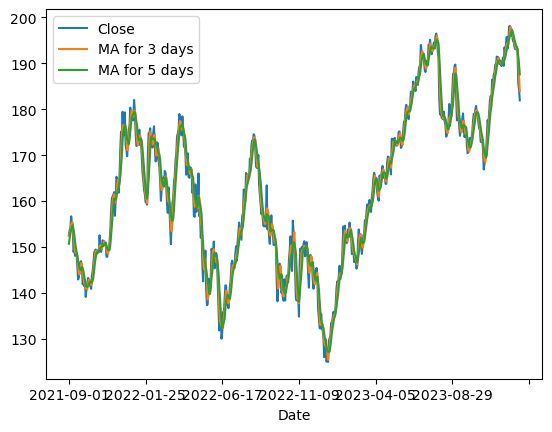

In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import datetime

def str_to_date(s):
    split = s.split('-')
    year, month, day = int(split[0]), int(split[1]), int(split[2])
    
    return datetime.datetime(year, month, day)

data = pd.read_csv('AAPL_2024.csv')
data = data[['Date', 'Close']]
data['Date'].apply(str_to_date)
data.index = data.pop('Date')


ma_day=[3,5,10,20,50]

for ma in ma_day:
    column_name = f"MA for {ma} days"
    data[column_name]=data['Close'].rolling(ma).mean()
# data = window_data(data.loc['2021-05-26': , :])
data_2021=data.loc['2021-09-01': , :]

# data_2021[['Close', 'MA for 10 days', 'MA for 20 days', 'MA for 50 days']].plot()
data_2021[['Close','MA for 3 days', 'MA for 5 days']].plot()

def data_to_date_X_y(df):
    dates = df.index
    
    arr = df.to_numpy()
    
    
    X = arr[:, 0:-1].reshape((len(dates), arr[:, 0:-1].shape[1], 1))
    y = arr[:, -1]
    
    return dates, X.astype(np.float32), y.astype(np.float32)

data_10 = data_2021.filter(['MA for 5 days']).values

from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(data_10)

# training data set 
p8 = int(np.ceil( len(data_10) * .60 ))
p9 = int(np.ceil( len(data_10) * .80 ))

train_data = scaled_data[0:p8, :]
val_data = scaled_data[p8:p9, :]
x_train = []
y_train = []
x_val = []
y_val = []

for i in range(60, len(train_data)):
    x_train.append(train_data[i-60:i, 0])
    y_train.append(train_data[i, 0])
    
for i in range(60, len(val_data)):
    x_val.append(val_data[i-60:i, 0])
    y_val.append(val_data[i, 0])
        

x_train, y_train = np.array(x_train), np.array(y_train)
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

x_val, y_val = np.array(x_val), np.array(y_val)
x_val = np.reshape(x_val, (x_val.shape[0], x_val.shape[1], 1))

In [15]:
from keras.models import Sequential
from keras.layers import Dense, LSTM
from keras.callbacks import EarlyStopping
from keras.optimizers import Adam
from keras import regularizers

# L2 regularization parameter
l2_lambda = 0.001

model = Sequential()
model.add(LSTM(64, return_sequences=True, input_shape= (x_train.shape[1], 1), kernel_regularizer=regularizers.l2(l2_lambda)))
model.add(LSTM(64, return_sequences=False, kernel_regularizer=regularizers.l2(l2_lambda)))
model.add(Dense(25, kernel_regularizer=regularizers.l2(l2_lambda)))
model.add(Dense(1))

optimizer = Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='mean_squared_error')
# Early stopping callback
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

model.fit(x_train, y_train, batch_size=64, epochs=200, validation_data=(x_val, y_val),callbacks=[early_stop])

Epoch 1/200
5/5 [==============================] - 2s 139ms/step - loss: 0.2793 - val_loss: 0.1960
Epoch 2/200
5/5 [==============================] - 0s 52ms/step - loss: 0.1581 - val_loss: 0.1258
Epoch 3/200
5/5 [==============================] - 0s 51ms/step - loss: 0.1388 - val_loss: 0.1802
Epoch 4/200
5/5 [==============================] - 0s 54ms/step - loss: 0.1327 - val_loss: 0.1667
Epoch 5/200
5/5 [==============================] - 0s 50ms/step - loss: 0.1211 - val_loss: 0.1179
Epoch 6/200
5/5 [==============================] - 0s 56ms/step - loss: 0.1135 - val_loss: 0.1053
Epoch 7/200
5/5 [==============================] - 0s 53ms/step - loss: 0.1062 - val_loss: 0.1145
Epoch 8/200
5/5 [==============================] - 0s 51ms/step - loss: 0.1002 - val_loss: 0.1118
Epoch 9/200
5/5 [==============================] - 0s 52ms/step - loss: 0.0941 - val_loss: 0.0933
Epoch 10/200
5/5 [==============================] - 0s 50ms/step - loss: 0.0890 - val_loss: 0.0838
Epoch 11/200
5/5 [

Epoch 84/200
5/5 [==============================] - 0s 53ms/step - loss: 0.0142 - val_loss: 0.0119
Epoch 85/200
5/5 [==============================] - 0s 52ms/step - loss: 0.0140 - val_loss: 0.0123
Epoch 86/200
5/5 [==============================] - 0s 52ms/step - loss: 0.0137 - val_loss: 0.0128
Epoch 87/200
5/5 [==============================] - 0s 53ms/step - loss: 0.0135 - val_loss: 0.0112
Epoch 88/200
5/5 [==============================] - 0s 53ms/step - loss: 0.0134 - val_loss: 0.0126
Epoch 89/200
5/5 [==============================] - 0s 52ms/step - loss: 0.0131 - val_loss: 0.0125
Epoch 90/200
5/5 [==============================] - 0s 55ms/step - loss: 0.0129 - val_loss: 0.0129
Epoch 91/200
5/5 [==============================] - 0s 56ms/step - loss: 0.0128 - val_loss: 0.0112
Epoch 92/200
5/5 [==============================] - 0s 67ms/step - loss: 0.0128 - val_loss: 0.0102
Epoch 93/200
5/5 [==============================] - 0s 54ms/step - loss: 0.0126 - val_loss: 0.0122
Epoch 94/2

In [16]:
test_data = scaled_data[p9 - 60: , :]

x_test = []
y_test = data_10[p9:, :]
for i in range(60, len(test_data)):
    x_test.append(test_data[i-60:i, 0])

x_test = np.array(x_test)

x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1 ))

# models predicted price values 
predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions)

# root mean squared error
rmse = np.sqrt(np.mean(((predictions - y_test) ** 2)))
rmse
acc =1.96 * rmse #95% confident that the error lies within the range
print(rmse)

from sklearn.metrics import r2_score

r2 = r2_score(y_test, predictions)
print(f"R-squared: {r2:.4f}")

4/4 [==============================] - 0s 7ms/step
2.895035073382485
R-squared: 0.8771


2/2 [==============================] - 0s 9ms/step


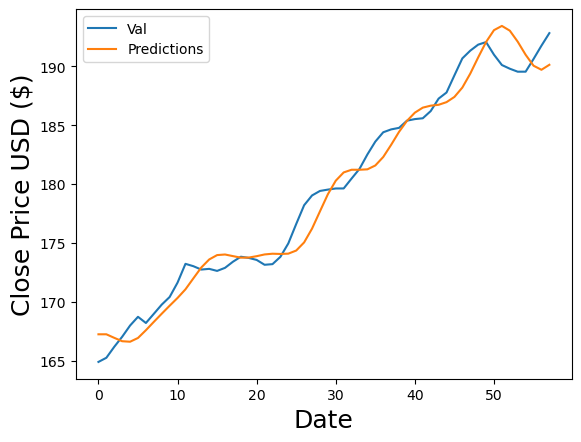

In [17]:
data_new=data_2021.filter(['MA for 5 days'])

val_pred = model.predict(x_val)
val_pred = scaler.inverse_transform(val_pred)

plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price USD ($)', fontsize=18)
plt.plot(scaler.inverse_transform(y_val.reshape(-1, 1)))
plt.plot(val_pred)
plt.legend(['Val','Predictions'])
plt.show()


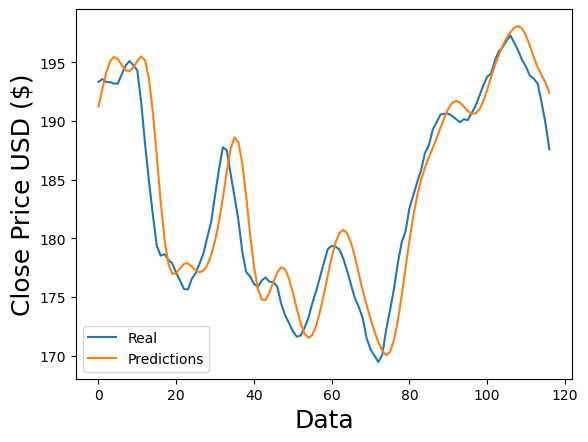

In [18]:
plt.xlabel('Data', fontsize=18)
plt.ylabel('Close Price USD ($)', fontsize=18)
plt.plot(y_test)
plt.plot(predictions)
plt.legend(['Real','Predictions'])
plt.show()

2/2 [==============================] - 0s 15ms/step


/var/folders/d4/868x7ffd6jb4lhp203myrtkc0000gn/T/ipykernel_95627/2857169710.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['Predictions'] = predictions


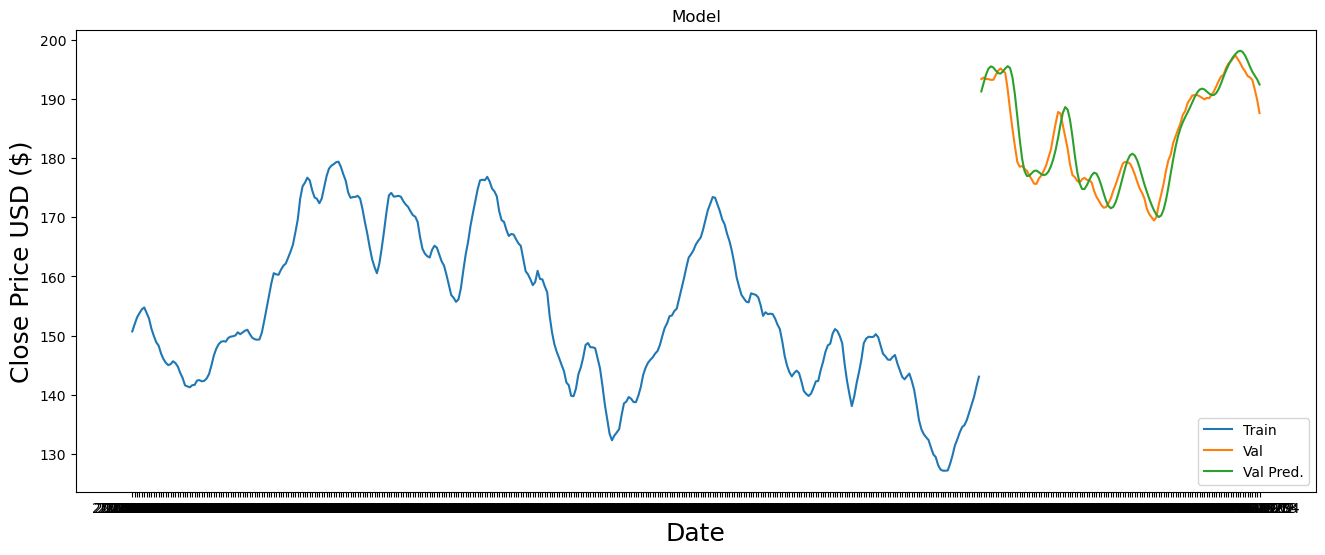

In [19]:
val_predictions = model.predict(x_val)
val_predictions = scaler.inverse_transform(val_predictions)

# Plot the data
train = data_new[:p8]
val = data_new[p8:p9]
# val['Predictions'] = val_predictions
test = data_new[p9:]
test['Predictions'] = predictions
# Visualize the data
plt.figure(figsize=(16,6))
plt.title('Model')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price USD ($)', fontsize=18)
plt.plot(train['MA for 5 days'])
# plt.plot(val[['MA for 5 days', 'Predictions']])
plt.plot(test[['MA for 5 days', 'Predictions']])
plt.legend(['Train', 'Val', 'Val Pred.', 'Text', 'Text Pred'], loc='lower right')
plt.show()

In [23]:
data_new[p9:]

,MA for 5 days
Date,
2023-07-20,193.328003
2023-07-21,193.578003
2023-07-24,193.330002
2023-07-25,193.308002
2023-07-26,193.188000
...,...
2023-12-28,193.612000
2023-12-29,193.182001
2024-01-02,191.589999


In [22]:
data_2021[p9:]

,Close,MA for 3 days,MA for 5 days,MA for 10 days,MA for 20 days,MA for 50 days
Date,,,,,,
2023-07-20,193.130005,193.986669,193.328003,191.432001,190.487000,182.782601
2023-07-21,191.940002,193.390004,193.578003,191.558002,190.734000,183.186001
2023-07-24,192.750000,192.606669,193.330002,191.972002,191.037501,183.569801
2023-07-25,193.619995,192.769999,193.308002,192.526001,191.455000,183.967201
2023-07-26,194.500000,193.623332,193.188000,192.999000,191.777000,184.405800
...,...,...,...,...,...,...
2023-12-28,193.580002,193.260000,193.612000,195.140001,194.179501,186.300001
2023-12-29,192.529999,193.086665,193.182001,194.582001,194.308501,186.633801
2024-01-02,185.639999,190.583333,191.589999,193.389000,194.028501,186.837400
